<a href="https://colab.research.google.com/github/bwsi-hadr/08-graph-optimization-tsp-dylan-pham/blob/master/08_Graph_Optimization_Problems_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (427 kB/s)
Selecting previously unselected package libspatialindex4

# Traveling Salesman Problem
The canonical Traveling Salesman Problem is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [0]:
place_name = 'Mountain View, CA, United States'
place_roads = ox.graph_from_place(place_name)


In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

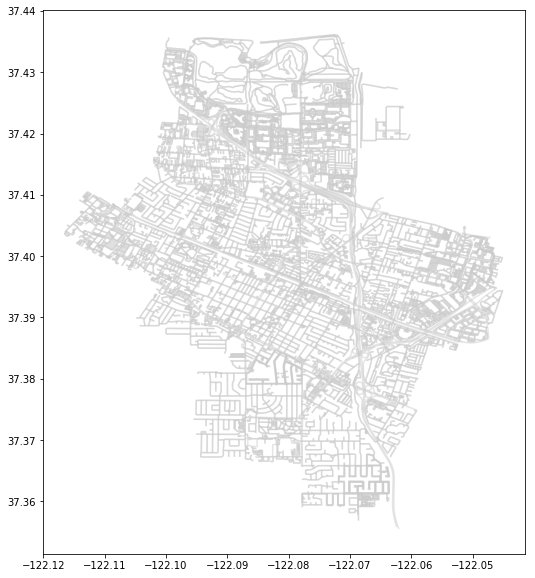

In [4]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [5]:
place_ice_cream = ox.pois_from_place(place_name, amenities=['ice_cream'])
place_ice_cream

,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,brand,brand:wikidata,brand:wikipedia,cuisine,element_type,geometry,name,old_name,opening_hours,operator,osmid,outdoor_seating,phone,shop,takeaway,url,website,wheelchair,building,nodes,source
343219779,NaN,241,NaN,NaN,Castro Street,ice_cream,NaN,NaN,NaN,ice_cream,node,POINT (-122.0791229 37.393258),Classico Gelato,NaN,NaN,NaN,343219779,yes,+1 650 969 2900,yes,yes,NaN,NaN,yes,NaN,NaN,NaN
2161945884,NaN,1249,NaN,NaN,West El Camino Real,ice_cream,NaN,NaN,NaN,NaN,node,POINT (-122.0889308 37.3879979),Baskin-Robbins,NaN,Mo-Su 11:00-22:00,NaN,2161945884,NaN,+1-650-940-9831,NaN,NaN,NaN,https://www.baskinrobbins.com/,NaN,NaN,NaN,NaN
3066022106,NaN,939,NaN,NaN,West El Camino Real,ice_cream,NaN,NaN,NaN,ice_cream,node,POINT (-122.0455695 37.3716377),Real Ice Cream,NaN,NaN,NaN,3066022106,NaN,+1 408 732 3350,NaN,NaN,NaN,http://realicecream.net,NaN,NaN,NaN,NaN
3224283661,Mountain View,292,NaN,CA,Castro Street,ice_cream,NaN,NaN,NaN,NaN,node,POINT (-122.0798241 37.3927738),Icicles,Buffalo,"Mo, We 13:00-22:00; Tu, Th 12:00-22:00; Fr-Su ...",NaN,3224283661,NaN,NaN,NaN,NaN,NaN,https://www.iciclescreamroll.com/,NaN,NaN,NaN,NaN
3391937391,Mountain View,703,94040,CA,East El Camino Real,ice_cream,Baskin-Robbins,Q584601,en:Baskin-Robbins,ice_cream,node,POINT (-122.0638584 37.3756404),Baskin-Robbins,NaN,NaN,Baskin Robbins,3391937391,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4537399470,Los Altos,4800,94022,CA,El Camino Real,ice_cream,NaN,NaN,NaN,NaN,node,POINT (-122.1103006 37.3988874),Smitten Ice Cream,NaN,"Mo-Su 12:00-22:00; Fr,Sa 12:00-22:30",NaN,4537399470,NaN,+1 650-559-0100,NaN,NaN,https://www.smittenicecream.com/locations/los-...,https://www.smittenicecream.com/,NaN,NaN,NaN,NaN
4887044340,NaN,NaN,NaN,NaN,NaN,ice_cream,Cold Stone Creamery,Q1094923,en:Cold Stone Creamery,ice_cream,node,POINT (-122.1141029 37.402777),Cold Stone Creamery,NaN,NaN,NaN,4887044340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116055412,NaN,260,NaN,NaN,NaN,ice_cream,Baskin-Robbins,Q584601,en:Baskin-Robbins,ice_cream,way,"POLYGON ((-122.1173166 37.3796285, -122.117244...",Baskin-Robbins,NaN,NaN,NaN,116055412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,"[1309675568, 1309675564, 1309675553, 130967555...",photograph


In [0]:
place_ice_cream['geometry'] = place_ice_cream.centroid

In [7]:
ice_cream_nodes = ox.get_nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

array([ 343588895, 4911384002,  152311607,   65620946,   73710410,
       3701896202,   86487248,   65418328])

## Exercise
Plot the locations of the ice cream shops on the map of the roads

In [0]:
mv_bounds = Polygon.from_bounds(*place_roads_edges.total_bounds)

In [0]:
mv_bounds = mv_bounds.buffer(0.001)

In [0]:
place_roads = ox.graph_from_polygon(mv_bounds)

In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

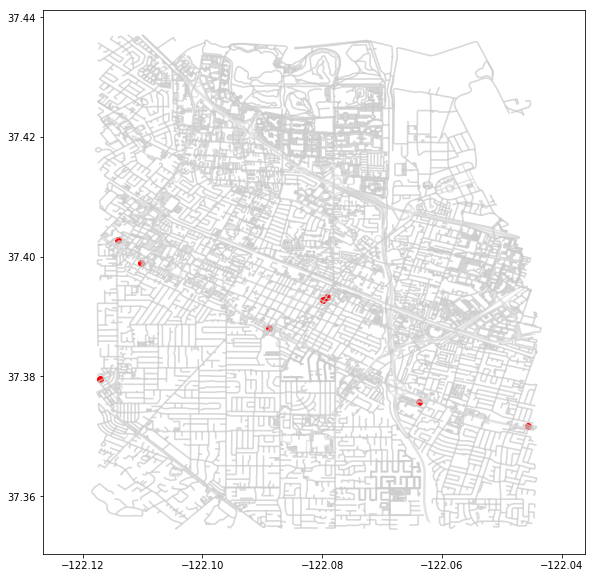

In [12]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_ice_cream.plot(ax=ax, color='red', )
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

# zorder parameter adjust layering

## Compute shortest path matrix

In [13]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
  for idx_j, dest in enumerate(ice_cream_nodes):
    shortest_path_matrix[idx_i, idx_j] = nx.shortest_path_length(place_roads, orig, dest, weight='length')
shortest_path_matrix

array([[   0.   , 1432.9  , 3348.191,   93.048, 3010.768, 3293.049,
        3792.801, 3069.741],
       [1309.38 ,    0.   , 3005.509, 1216.332, 2668.086, 2440.304,
        2985.184, 1923.684],
       [3887.894, 3715.238,    0.   , 3794.846,  865.687, 5866.236,
        6411.116, 5352.079],
       [  93.048, 1339.852, 3256.531,    0.   , 2919.108, 3200.979,
        3700.731, 2976.693],
       [3022.207, 2849.551,  516.139, 2929.159,    0.   , 5000.549,
        5545.429, 4486.392],
       [3310.384, 2335.515, 5341.024, 3219.699, 5003.601,    0.   ,
         613.316, 1868.81 ],
       [3899.855, 2896.012, 5901.521, 3809.17 , 5564.098,  674.909,
           0.   , 2429.307],
       [2981.217, 1671.837, 4677.346, 2888.169, 4339.923, 1868.348,
        2413.228,    0.   ]])

In [0]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [15]:
# new graph indexes from 0
ice_cream_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [16]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})
ice_cream_graph.nodes

NodeView((343588895, 4911384002, 152311607, 65620946, 73710410, 3701896202, 86487248, 65418328))

## Exercise
Find the best TSP path you can

In [54]:
import math

shortest_distance_found = False
points = place_ice_cream['geometry']
points_visited = []

current_point = points.iloc[0]
total_distance = 0

while(True):
    shortest_distance = math.inf

    for i in range(1, points.shape[0]):
        if points.iloc[i] not in points_visited:
            if shortest_distance > current_point.distance(points.iloc[i]):
                shortest_distance = current_point.distance(points.iloc[i])
            else:
                continue

            points_visited.append(current_point)
            next_point = points.iloc[i]
            current_point = next_point
            total_distance += shortest_distance

    if len(points_visited)+1 == points.shape[0]:
        print(total_distance)
        break

# not finished

0.011129400451955151
0.01028305429821582
0.04025061917995525
0.018721791327222674
0.0
0.05193554611092503
0.005439344946777636
0.13775975631505158


In [0]:
ox.add_path()